In [2]:
# !pip install --quiet optuna
# !pip install --quiet stellargraph

In [1]:
import os
import optuna
from optuna.trial import TrialState

In [2]:
import pandas as pd
import numpy as np
import torch
import random
import math
import torch.optim as optim

In [3]:
from torch.utils.data import DataLoader, TensorDataset

# Data prep

In [4]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3
pre_len = 1

#adjacency matrix
grid_points = pd.read_csv('../Data/grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [5]:
def data_preparation(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # only PM2_5
    df = df[['dateTime','lat','long','pm2_5']]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 

    # only PM2_5
#     df = df[['dateTime','lat_grid','long_grid','pm2_5
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
    columns = df.columns
#     df = df[columns[2:]]
    df = df.fillna(0)
    
    return df

In [8]:
df = data_preparation('../PM Datasets/2020-12-01_all.csv')

In [9]:
df

dateTime                  360         540         720         900   \
lat_grid long_grid                                                   
0        22         274.869242  275.605369  185.320702  142.292380   
1        21         277.657143  290.829787  191.355140  133.500000   
         22         274.326007  286.357724  210.973510  143.156716   
2        21         276.337884  294.913357  194.714286  130.401198   
         22         309.000000    0.000000    0.000000  120.750000   
...                        ...         ...         ...         ...   
18       20         319.370370  335.133333  312.354839  189.211268   
         23         293.303030  305.217391    0.000000  203.821429   
         24         309.564706  319.508772    0.000000  194.931624   
19       19         338.242424  350.683333  294.000000  179.868421   
         20         326.805970  324.847162  268.331370  197.803704   

dateTime                  1080        1260  
lat_grid long_grid                          
0        22         210.565693  303.773973  
1        21         184.521739  309.384615  
         22         195.157143  279.916667  
2        21         190.013514  311.555556  
         22           0.000000    0.000000  
...                        ...         ...  
18       20         182.400000  504.166667  
         23           0.000000    0.000000  
         24           0.000000    0.000000  
19       19         208.177778    0.000000  
         20         212.255319    0.000000  

[130 rows x 6 columns]

In [6]:
def train_test_split(df, grid_points_indices, train_size):
    # random.seed(10)
    time_len = df.shape[1]
    train_size = int(time_len * train_size) 
    train_data = df.iloc[:, :train_size]
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)
    test_data = df.iloc[:, train_size:]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [7]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [8]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [9]:
def prepare_train_data(df, grid_points_indices, train_size = 0.8):
    train_data, test_data = train_test_split(df, grid_points_indices, train_size)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

# Training

In [32]:
def my_loss(y_true, y_pred):
    a = y_pred[y_true > 0] - y_true[y_true > 0]
    return torch.sum(a**2), len(a)

In [11]:
def eval_model(model, testX, testY):
    output = model(torch.Tensor(testX))
    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)
    ## Rescale model predicted values
    test_output = np.array((output.detach().numpy() * (max_pm - min_pm)) + min_pm)
    # # Masked predicted values\
    mask_test = torch.sign(torch.Tensor(testY))
    test_output = torch.Tensor(test_output)*(mask_test)
    test_mse = my_loss(torch.Tensor(test_true), torch.Tensor(test_output))
    test_rmse = torch.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [12]:
def get_out_df(train_rmse, validation_rmse):
    max_pm = train_data.max()
    min_pm = train_data.min()
    scale_factor = max_pm - min_pm
    df = pd.DataFrame()
    df['Mean Train loss'] = [sum(train_rmse)*scale_factor/len(train_rmse)]
    df['Last Train loss'] = [train_rmse[-1]*scale_factor]
    df['Mean Test loss'] = [sum(validation_rmse)*scale_factor/len(validation_rmse)]
    df['Last Test loss'] = [validation_rmse[-1]*scale_factor]
    # df['Train time callbacks'] = [sum(cb.logs)]
    return df

In [13]:
def plot_predictions(test_output, test_true, save_path=None):
    ##all test result visualization
    fig = plt.figure(figsize=(15, 8))
    # test_output, test_true = eval(model, testX, testY )
    a_pred = test_output[test_true>0]
    a_true = test_true[test_true>0]
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("test points")
    plt.ylabel("PM2.5")
    plt.legend(loc="best", fontsize=10)
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Initialize The Model

In [18]:
# df = data_preparation('../dataset/Dec/2020-12-1_all.csv')
# for i in range(2, 8):
#     datafile = '../dataset/Dec/2020-12-'
#     datafile +=  str(i) if i<10 else str(i)
#     datafile +=  '_all.csv'
#     df1 = data_preparation(datafile)
#     df = pd.concat([df,df1], axis=1)
df = pd.read_pickle('../dataset/df.pkl')
df.head()

pm2_5                                                 \
dateTime                  360         540         720        900         1080   
lat_grid long_grid                                                              
0        21           0.000000    0.000000    0.000000   0.000000    0.000000   
         22         502.792722  392.439383  135.177801  79.938086  100.638132   
1        19           0.000000    0.000000    0.000000   0.000000    0.000000   
         20           0.000000    0.000000    0.000000   0.000000    0.000000   
         21         497.476190  419.319149  166.090909  80.000000  108.244898   

                               temperature                                   \
dateTime                  1260        360        540        720        900    
lat_grid long_grid                                                            
0        21           0.000000    0.000000   0.000000   0.000000   0.000000   
         22         205.528261   28.164810  33.199229  39.165653  41.068987   
1        19           0.000000    0.000000   0.000000   0.000000   0.000000   
         20           0.000000    0.000000   0.000000   0.000000   0.000000   
         21         171.230769   28.107619  30.745106  36.227879  39.995152   

                    ...                                              \
dateTime            ...       720        900        1080       1260   
lat_grid long_grid  ...                                               
0        21         ...   0.000000   0.000000   0.000000   0.000000   
         22         ...  33.883309  38.284676  33.497511  31.497349   
1        19         ...  32.116087  35.843485  33.544878  28.190816   
         20         ...  31.621383  35.760748  33.537105  28.307297   
         21         ...  33.908036  36.528707  33.440157  30.562114   

                     humidity                                              \
dateTime                 360        540        720        900        1080   
lat_grid long_grid                                                          
0        21          0.000000   0.000000   0.000000   0.000000   0.000000   
         22         37.281299  33.045750  17.565923  10.027471  17.354318   
1        19         40.724842  31.743862  21.185037  13.343424  18.846108   
         20         40.829375  31.436071  20.988053  13.266556  19.039448   
         21         37.335145  32.350479  17.495841  12.534485  18.428549   

                               
dateTime                 1260  
lat_grid long_grid             
0        21          0.000000  
         22         20.931174  
1        19         25.504135  
         20         25.292335  
         21         22.936116  

[5 rows x 1548 columns]

In [23]:
trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.86)

Train data:  (270, 1331)
Test data:  (270, 217)
(1328, 270, 3)
(1328, 270)
(214, 270, 3)
(214, 270)


In [68]:
from gcn_lstm import GCN_LSTM
import numpy as np
import torch
adj = adj.astype(np.float32)
model=GCN_LSTM(torch.from_numpy(adj), grid_size = 270, seq_len = 3, gc_sizes = [16, 8, 4], lstm_sizes = [8, 4])
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-05)

In [25]:
for param in model.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([270, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([270])


In [31]:
def train_model(model, optimizer, trainX, trainY, testX, testY, n_epochs, batch_size):
    # convert all data to tensor
    trainX = torch.from_numpy(trainX.astype(np.float32))
    trainY = torch.from_numpy(trainY.astype(np.float32))
    testX = torch.from_numpy(testX.astype(np.float32))
    testY = torch.from_numpy(testY.astype(np.float32))
    
    trainDs = TensorDataset(trainX, trainY)
    testDs = TensorDataset(testX, testY)
    trainLoader = DataLoader(trainDs, batch_size=batch_size, shuffle=True)
    testLoader = DataLoader(testDs, batch_size=batch_size, shuffle=False)

    train_mse, train_rmse, validation_mse, validation_rmse=[], [], [], []
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_len = 0
        valid_len = 0
        for _, (inputs, targets) in enumerate(trainLoader):
            model.train()
            outputs = model(inputs)
            loss, tlen = my_loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_len += tlen
        
        with torch.no_grad():
            for _, (inputs, targets) in enumerate(testLoader):
                model.eval()
                outputs = model(inputs)
                loss, tlen = my_loss(outputs, targets)
                valid_loss += loss.item()
                valid_len += tlen

        train_loss /= train_len
        valid_loss /= valid_len
        train_mse.append(train_loss)
        validation_mse.append(valid_loss)
        train_rmse.append(math.sqrt(train_loss))
        validation_rmse.append(math.sqrt(valid_loss))

        if((epoch+1)%10==0):
            print(f'Epoch {epoch+1} \t Train Loss: ', {train_loss}, 'Valid Loss: ', {valid_loss})

    return train_mse, train_rmse, validation_mse, validation_rmse

Epoch 10 	 Train Loss:  {0.004859708936445312} Valid Loss:  {0.00379723948811775}
Epoch 20 	 Train Loss:  {0.004825623314171058} Valid Loss:  {0.0037980012061811313}
Epoch 30 	 Train Loss:  {0.0048549520017206} Valid Loss:  {0.003802383049172322}
Epoch 40 	 Train Loss:  {0.004847248549548604} Valid Loss:  {0.003798459483166804}
Epoch 50 	 Train Loss:  {0.004854867899593419} Valid Loss:  {0.0037999699461538513}
Epoch 60 	 Train Loss:  {0.004842218969454461} Valid Loss:  {0.003794195165927949}
Epoch 70 	 Train Loss:  {0.004841218495783876} Valid Loss:  {0.003800799938253401}
Epoch 80 	 Train Loss:  {0.004848885677159764} Valid Loss:  {0.0037872255611848815}
Epoch 90 	 Train Loss:  {0.00484827711400258} Valid Loss:  {0.003797533900814512}
Epoch 100 	 Train Loss:  {0.004830805880849992} Valid Loss:  {0.003789860527999841}


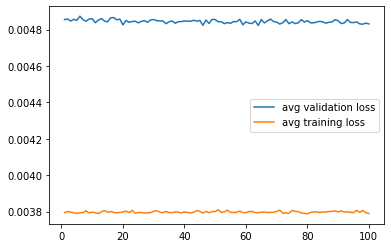

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,61.770719,61.684143,54.68914,54.635555


In [72]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 100, 20)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

In [84]:
trainY[0]

array([0.        , 0.09007204, 0.        , 0.        , 0.0901418 ,
       0.09168873, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10074794, 0.07605715, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08018865, 0.09328407, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08869089, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08768104, 0.08910171,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09933627, 0.08509181, 0.08647559, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09475133,
       0.09417279, 0.08492809, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [73]:
predY0 = model(torch.tensor(trainX[0]).float().unsqueeze(0))
predY0

tensor([[0.0045, 0.0966, 0.0417, 0.0423, 0.0915, 0.0919, 0.0006, 0.0008, 0.0011,
         0.0010, 0.0406, 0.0006, 0.0930, 0.0362, 0.0008, 0.0007, 0.0007, 0.0006,
         0.0373, 0.0393, 0.0860, 0.0919, 0.0007, 0.0005, 0.0007, 0.0016, 0.0438,
         0.0005, 0.0915, 0.0008, 0.0007, 0.0192, 0.0210, 0.0007, 0.0006, 0.0006,
         0.0422, 0.0431, 0.0918, 0.0915, 0.0005, 0.0004, 0.0240, 0.0246, 0.0249,
         0.0266, 0.0007, 0.0007, 0.0007, 0.0007, 0.0864, 0.0920, 0.0922, 0.0305,
         0.0321, 0.0007, 0.0250, 0.0249, 0.0006, 0.0005, 0.0262, 0.0005, 0.0011,
         0.0007, 0.0906, 0.0923, 0.0916, 0.0279, 0.0313, 0.0322, 0.0234, 0.0246,
         0.0750, 0.0784, 0.0793, 0.0832, 0.0822, 0.0863, 0.0909, 0.0913, 0.0914,
         0.0783, 0.0649, 0.0309, 0.0192, 0.0231, 0.0808, 0.0006, 0.0006, 0.0010,
         0.0623, 0.0667, 0.0694, 0.0873, 0.0142, 0.0792, 0.0738, 0.0812, 0.0761,
         0.0005, 0.0005, 0.0006, 0.0626, 0.0570, 0.0550, 0.0886, 0.0301, 0.0766,
         0.0174, 0.0006, 0.0

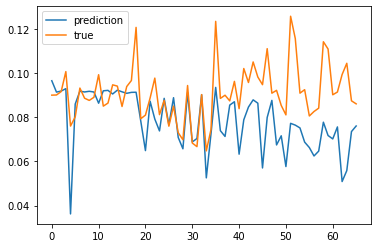

In [85]:
plt.plot(predY0.detach().numpy()[0][trainY[0]!=0], label='prediction')
plt.plot(trainY[0][trainY[0]!=0], label='true')
plt.legend()

In [63]:
predY0.shape, trainY[0].shape

(torch.Size([1, 270]), (270,))

In [28]:
torch.__version__

'1.10.1'

Epoch 10 	 Train Loss:  {0.015000437753218594} Valid Loss:  {0.012313256040215492}
Epoch 20 	 Train Loss:  {0.015073561815149857} Valid Loss:  {0.01221839152276516}
Epoch 30 	 Train Loss:  {0.01502170137157946} Valid Loss:  {0.012591897509992123}
Epoch 40 	 Train Loss:  {0.014965334878952213} Valid Loss:  {0.01260360423475504}
Epoch 50 	 Train Loss:  {0.015021580920526476} Valid Loss:  {0.012582563795149326}
Epoch 60 	 Train Loss:  {0.01500758726262685} Valid Loss:  {0.012276440858840942}
Epoch 70 	 Train Loss:  {0.0149849479114919} Valid Loss:  {0.012622183188796043}
Epoch 80 	 Train Loss:  {0.01509306032323476} Valid Loss:  {0.012836821377277374}
Epoch 90 	 Train Loss:  {0.014958257786929607} Valid Loss:  {0.012351948767900467}
Epoch 100 	 Train Loss:  {0.015101136639714241} Valid Loss:  {0.012372645549476147}


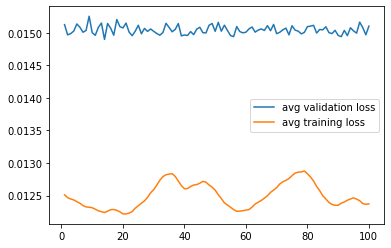

,Mean Train loss,Last Train loss,Mean Test loss,Last Test loss
0,78.877674,79.031497,71.885731,71.536334


In [30]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, optimizer, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg validation loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg training loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

In [31]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(model, trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)

TypeError: train_model() missing 1 required positional argument: 'batch_size'

In [ ]:
train_mse, train_rmse, validation_mse, validation_rmse = train_model(trainX, trainY, testX, testY, 100, 23)
from matplotlib import pyplot as plt
plt.plot(np.arange(1, 101), train_mse, label='avg training loss')
plt.plot(np.arange(1, 101), validation_mse, label='avg validation loss')
plt.legend()
plt.show()
get_out_df(train_rmse, validation_rmse)